## Exploratory Plots To Make Sense of Weird Fis Distribution

**20170425**

The Fis distribution of SNPs was bimodal, with most Fis values positive. This is pretty weird compared to the results of my peers.

This plot is the Fis distribution of SNPs that are in RAD tags without SNPs in the first or last 30 base pairs:

![image](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_run1/Analyses/Fis/fis_dist_SNPs_30cutoff_20170420.png?raw=true)

So, my adviser suggested that I assess the following, to try and make some sense of the weirdness in the Fis distribution, and to try to get at whether this is biological or just an error.

* Plot Fis by heterozygosity
* Plot read depth by Fis
* Plot read depth by heterozygosity
* Plot Fis by sequence position
* Plot Heterozygosity by sequence position
* Visually assess some sequences and see if obvious paralogous loci

**20170426**

First, though I filtered my SNPs so that I have just one per RAD tag. Notebook [here](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_run1/Notebooks/script_demos/filter_one_SNP_per_RADtag.py.ipynb), script [here](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_run1/Scripts/filtering/filter_one_SNP_per_RADtag.py).

Now that I've filtered only one SNP per RAD tag, I'm going to rerun hierfstat in R. Code [here](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_run1/Scripts/Fis/HIERFSTAT_tags_cragigrun1_asONEPOP_oneSNPperRADtag_20170426.R)

Let's check out Fis and Hs distribution now that I've filtered out just one SNP per RAD tag.

In [74]:
cd /mnt/hgfs/SHARED_FOLDER/WorkingFolder

/mnt/hgfs/SHARED_FOLDER/WorkingFolder


In [75]:
import matplotlib.pyplot as plt
import numpy as np

In [76]:
fis_hs_file = open("SNPs_asONEPOP_oneSNPpertag_Hs_Fis.csv", "r")
lines = fis_hs_file.readlines()
fis_hs_file.close()

In [77]:
file_as_list_o_lists = []
Fis = []
Hs = []
Ho = []
SNP_names = []
for line in lines:
    linelist = line.strip().split(",")
    file_as_list_o_lists.append(linelist)
    if linelist[1] != "NA" and linelist[1] != "Fis":
        Fis.append(float(linelist[1]))
    if linelist[2] != "NA" and linelist[2] != "Hs":
        Hs.append(float(linelist[2]))
    if linelist[0] != "All_pops":
        SNP_names.append(linelist[0])
    if linelist[3] != "NA" and linelist[3] != "Ho":
        Ho.append(float(linelist[3]))

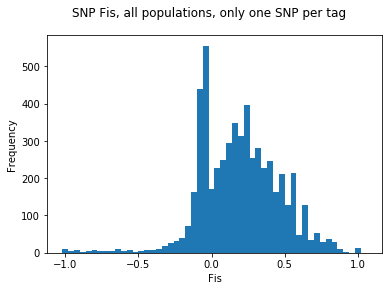

In [26]:
plt.hist(Fis, bins = np.arange(-1, 1.1, .04)-.02)
plt.suptitle("SNP Fis, all populations, only one SNP per tag")
plt.xlabel("Fis")
plt.ylabel("Frequency")
plt.show()

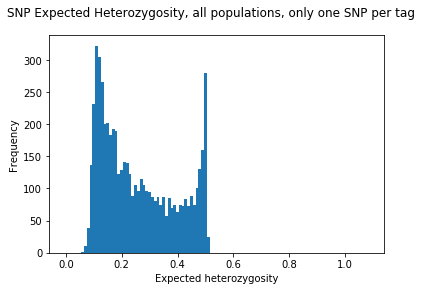

In [79]:
plt.hist(Hs, bins = np.arange(0, 1.1, .01)-.005)
plt.suptitle("SNP Expected Heterozygosity, all populations, only one SNP per tag")
plt.xlabel("Expected heterozygosity")
plt.ylabel("Frequency")
plt.show()

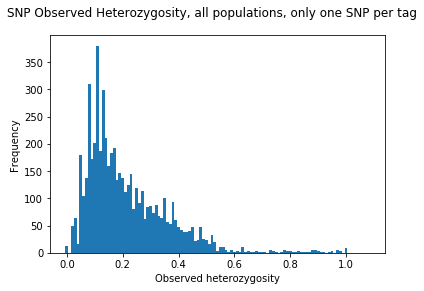

In [80]:
plt.hist(Ho, bins = np.arange(0, 1.1, .01)-.005)
plt.suptitle("SNP Observed Heterozygosity, all populations, only one SNP per tag")
plt.xlabel("Observed heterozygosity")
plt.ylabel("Frequency")
plt.show()

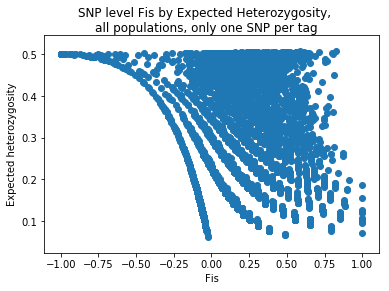

In [82]:
plt.scatter(Fis, Hs)
plt.suptitle("SNP level Fis by Expected Heterozygosity, \nall populations, only one SNP per tag")
plt.xlabel("Fis")
plt.ylabel("Expected heterozygosity")
plt.show()

That one is so beautiful, but maybe beautifully terrifying. Will ask my adviser... in the mean time, on to plotting Fis and Hs by SNP position

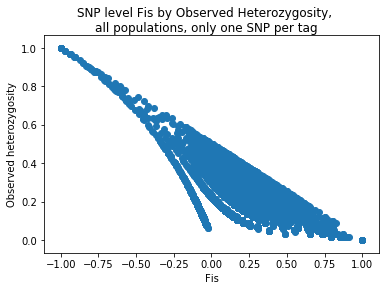

In [81]:
plt.scatter(Fis, Ho)
plt.suptitle("SNP level Fis by Observed Heterozygosity, \nall populations, only one SNP per tag")
plt.xlabel("Fis")
plt.ylabel("Observed heterozygosity")
plt.show()

In [102]:
# get SNP positions into list, in order of Hs and Fis file

SNP_positions = []
RADtag_names = []

for SNP_name in SNP_names:
    namelist = SNP_name.split("_")
    SNP_position = int(namelist[1])
    SNP_positions.append(SNP_position)
    RADtag_name = int(namelist[0])
    RADtag_names.append(RADtag_name)

In [32]:
SNP_positions[0:9] # check worked ... it did!

[137, 72, 52, 30, 69, 22, 90, 87, 59]

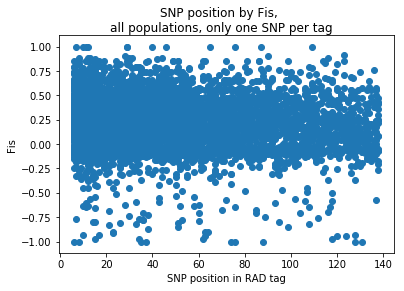

In [33]:
plt.scatter(SNP_positions, Fis)
plt.suptitle("SNP position by Fis, \nall populations, only one SNP per tag")
plt.xlabel("SNP position in RAD tag")
plt.ylabel("Fis")
plt.show()

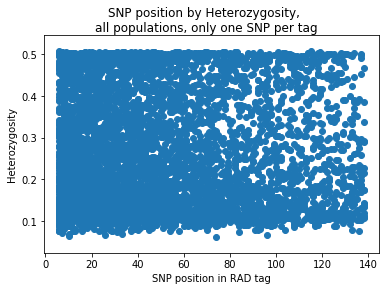

In [34]:
plt.scatter(SNP_positions, Hs)
plt.suptitle("SNP position by Heterozygosity, \nall populations, only one SNP per tag")
plt.xlabel("SNP position in RAD tag")
plt.ylabel("Heterozygosity")
plt.show()

Looks like there is a weak relationship between sequence position in Fis, and sequence position and heterozygosity.

Now to get average tag read depth (and maybe variance in tag read depth). Going to take and adjust some code from this [read depth notebook](https://github.com/nclowell/RAD_Scallops/blob/master/CRAGIG_run1/Notebooks/data_processing/read_depth.ipynb).

In [ ]:
cd /mnt/hgfs/SHARED_FOLDER/WorkingFolder

In [37]:
# get file names from matches list text file
file_of_filenames = open("Stacks_2/list_matches_filenames.txt","r") # change to args.matchfiles
lines = file_of_filenames.readlines()
filename_list = []
for line in lines:
    filename = line.strip()
    filename_list.append(filename)
num_files = len(filename_list) # get num files
file_of_filenames.close()

In [73]:
# initiate dictionary to store a list of read depths per RAD tag
# keys will be RAD tag name (integer)
# values will be list of read counts (list of integers)
tag_rdepths = {}

# debugging... see how many times locus goes through third part of loop
firstloopcount = 0
secondloopcount = 0
thirdloopcount = 0

for eachfile in filename_list:
    indfile = open("Stacks_2" + "/" + eachfile,"r")
    lines = indfile.readlines()[1:]
    thisfile_tag_names = []
    for line in lines:
        linelist = line.strip().split()
        locus = int(linelist[2]) # get catalog locus name
        count = int(linelist[6]) # get read count for this locus
        if locus not in tag_rdepths:
            firstloopcount += 1
            tag_rdepths[locus] = [int(count)]
        elif (locus in tag_rdepths and locus in thisfile_tag_names):
            secondloopcount += 1
            allele1count = tag_rdepths[locus][-1]
            bothcount = allele1count + count
            tag_rdepths[locus][-1] = bothcount
        elif (locus in tag_rdepths and locus not in thisfile_tag_names):
            thirdloopcount += 1
            rdlist = tag_rdepths[locus]
            rdlist.append(count)
            tag_rdepths[locus] = rdlist    
        else:
            print "Something funky is going on."
        thisfile_tag_names.append(locus) # store names of tags into list, to account for heterozygotes down the line

    indfile.close()

# debugging...
print "Went through first loop " + str(firstloopcount) + " times"
print "Went through second loop " + str(secondloopcount) + " times"
print "Went through third loop " + str(thirdloopcount) + " times"

Went through first loop 27460 times
Went through second loop 361238 times
Went through third loop 1173371 times


In [69]:
# double-checking no redundant keys in dict to debug
print len(tag_rdepths.keys())
print len(list(set(tag_rdepths.keys())))
# nums should match

27460
27460


In [91]:
# check that it worked
# ---should have up to 66 items per list
# ---read depths are usually around 100 reads
print len(tag_rdepths[5])
print tag_rdepths[5]

print len(tag_rdepths[10])
print tag_rdepths[10]

print len(tag_rdepths[15])
print tag_rdepths[15]

# looks accurate from spot checking!

67
[213, 290, 142, 133, 190, 135, 92, 175, 162, 262, 148, 164, 158, 172, 308, 200, 424, 109, 124, 165, 343, 299, 384, 153, 258, 240, 305, 201, 159, 89, 153, 120, 118, 148, 143, 260, 140, 247, 208, 139, 107, 133, 250, 316, 182, 392, 300, 301, 129, 91, 385, 182, 147, 120, 135, 231, 286, 260, 92, 415, 194, 243, 91, 17, 194, 52, 262]
56
[10, 41, 36, 33, 48, 79, 14, 14, 16, 10, 68, 147, 64, 90, 16, 22, 105, 23, 424, 38, 14, 125, 51, 49, 66, 65, 114, 83, 59, 10, 116, 234, 126, 57, 18, 41, 41, 128, 78, 11, 63, 114, 31, 26, 38, 126, 22, 224, 16, 48, 97, 152, 84, 12, 33, 42]
20
[109, 76, 145, 130, 164, 123, 242, 45, 333, 77, 162, 65, 186, 112, 63, 67, 179, 123, 12, 150]


In [92]:
# initiate dictionaries to store means and variances of read depths per tag
tag_mean_rd = {}
tag_variance_rd = {}

for tag in tag_rdepths.keys():
    tag_mean_rd[tag] = np.mean(tag_rdepths[tag])
for tag in tag_rdepths.keys():
    tag_variance_rd[tag] = np.var(tag_rdepths[tag])

In [100]:
print tag_mean_rd[15]
print tag_variance_rd[15]

128.15
5122.3275


In [94]:
RADtag_names[0:9] # ordered list of RADtag names

['5', '13', '20', '27', '31', '57', '62', '63', '75']

In [103]:
rd_means = [] 
rd_vars = []

for RADtag_name in RADtag_names: # get means and vars from ordered SNP name list
    rd_means.append(tag_mean_rd[RADtag_name])
    tag_rd_var = tag_variance_rd[RADtag_name]

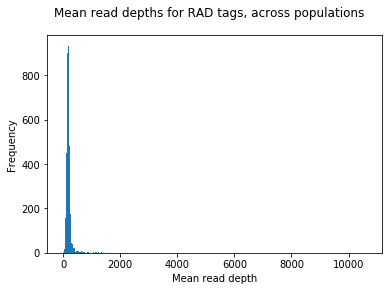

In [105]:
plt.hist(rd_means, bins = np.arange(0,max(rd_means)+1,20)-25)
plt.suptitle("Mean read depths for RAD tags, across populations")
plt.xlabel("Mean read depth")
plt.ylabel("Frequency")
plt.show()

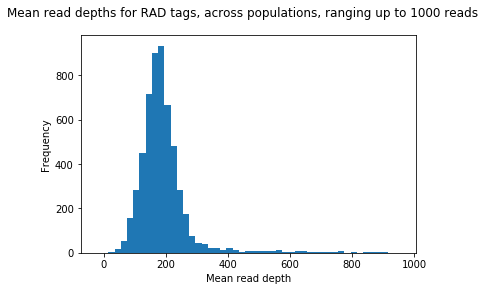

In [107]:
# And again but looking at smaller range...

plt.hist(rd_means, bins = np.arange(0,1000,20)-25)
plt.suptitle("Mean read depths for RAD tags, across populations, ranging up to 1000 reads")
plt.xlabel("Mean read depth")
plt.ylabel("Frequency")
plt.show()

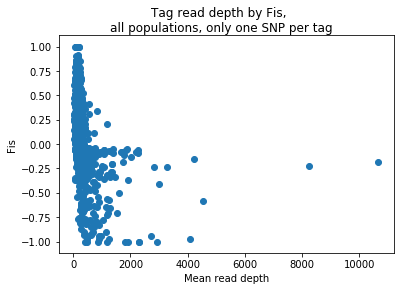

In [108]:
plt.scatter(rd_means, Fis)
plt.suptitle("Tag read depth by Fis, \nall populations, only one SNP per tag")
plt.xlabel("Mean read depth")
plt.ylabel("Fis")
plt.show()

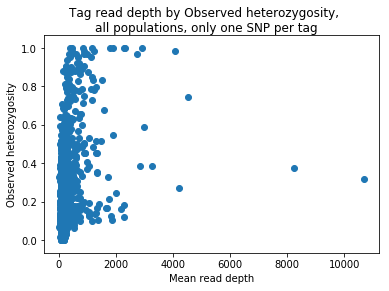

In [109]:
plt.scatter(rd_means, Ho)
plt.suptitle("Tag read depth by Observed heterozygosity, \nall populations, only one SNP per tag")
plt.xlabel("Mean read depth")
plt.ylabel("Observed heterozygosity")
plt.show()

### Just want to make sure if we shrink the scale of the x axis, the pattern doesn't change...

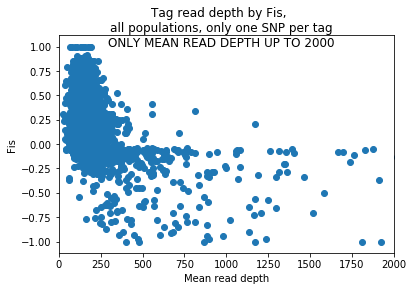

In [113]:
plt.scatter(rd_means, Fis)
plt.suptitle("Tag read depth by Fis, \nall populations, only one SNP per tag\nONLY MEAN READ DEPTH UP TO 2000")
plt.xlabel("Mean read depth")
plt.ylabel("Fis")
plt.xlim(0,2000)
plt.show()

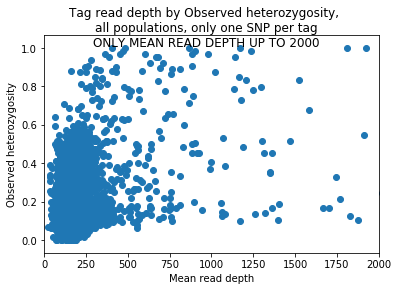

In [114]:
plt.scatter(rd_means, Ho)
plt.suptitle("Tag read depth by Observed heterozygosity, \nall populations, only one SNP per tag\nONLY MEAN READ DEPTH UP TO 2000")
plt.xlabel("Mean read depth")
plt.ylabel("Observed heterozygosity")
plt.xlim(0,2000)
plt.show()

## Visually assess whether we have a paralogous loci problem

**20170426**

My adviser wanted me to look at a bunch of sequences and just check whether paralogous loci may have gotten through our filtering steps, as they could explain some of the funky things we're observing. I'm not sure that visually assessing will be very possible, but Mary made a great suggestion that I could try the bowtie filtering again with less stringent parameters, see what boots out, and compare it to what remains, etc. Essentially it may be useful to use bowtie to better understand how similar loci in my catalog are.

Just in case... here are some sequences in the catalog.

-use catalog tags file, extract sequences, list

In [117]:
cd /mnt/hgfs/SHARED_FOLDER/WorkingFolder/Stacks_2

/mnt/hgfs/SHARED_FOLDER/WorkingFolder/Stacks_2


In [118]:
cat_tags = open("batch_100.catalog.tags.tsv", "r")
cat_tags_lines = cat_tags.readlines()
cat_tags.close()

In [120]:
tag_seqs = []
for line in cat_tags_lines[1:]: # exclude header
    linelist = line.strip().split()
    seq = linelist[9]
    tag_seqs.append(seq)

In [121]:
tag_seqs[0:9] # make sure extracting correct info... yes!

['TGCAGGGACATTTTGGCTTAGTGTTGTTTTCATTTTGACATTTAGCTCAATGGCATGCCATATAACTAATGAAGTGCAATTCATATGAGCATACTACTTTTTTTCAACCTTTTTATATAAAAAAAAATATTTTATACTC',
 'TGCAGGAAAGTACATGCTTCAAAGTCAATTGTTTTGATGGGCACATGAATAGGGTCACGCAGGTTCTTTCTACTTAACCTACAAGTATTTACATACCAATACATTGAGCAGTGCTACATGTAGGTGTTTTCTCTGAACT',
 'TGCAGGTTTTTCTCTTTTGAATATAAATAGTTTCTTCAAAAATGTCGAAATGAGTTAACTCAGTGTATAAAAAAAGTGATGAACAACACATATTTTTGTAGGCCTTCTGCAGCGGAACTGTTTTTGGTCGATCGCCGGC',
 'TGCAGGTGAGAAATATGTGTGAACTTTACATGAAATATTTATCCAATTAGTTTATAATAAAGTATATACAAAAGAAAATATCAATTAAAACTTGATACCCTATTCATCTCATTAAGTGCAATTTAAGTACATTGAGATC',
 'TGCAGGTAGCTTATTTGGTTAGGGCGAGAGTCCCTGCATCGATAGGTGCAAATTACCCAAATTGTAACGACAACAAAAATTGTCCTTTATCTGGTTTACGTGCCGTCATAGATTAAATTTCCCAGGCATTACATGAGAC',
 'TGCAGGTAGGCTGTAAGAATTGTACCTGCTACCCCCATTGCATGATCGTAAGAGGCGACTAAGTATGGGACCTTATCTTTTCTCTTCTTTCTAAACAACTTTTTCCTAATGTCTTCCTTGACAATGCCTCACTTTCGGC',
 'TGCAGGCAGGGCGTAAGAATTGTACTTGCTGCCCCCATTGCATGATCGTAAGAGGCGACTAAATTTGTCATCTTATCTTTTCTTCTTTTTAAACATCTTTCTTCTTCATAATGTCTCCCTTGACAATGCCTCAC

In [123]:
# write seqs to text file

outfile = open("../tag_sequences_20170426.txt", "w")
for tag_seq in tag_seqs[0:100]:
    outfile.write(tag_seq + "\n")
outfile.close()